In [1]:
import pandas
import numpy as np
pandas.set_option('display.max_columns', 20)
pandas.set_option('display.width', 350)

In [2]:
data = pandas.read_csv('https://drive.google.com/uc?export=download&id=1nhZhMk_2SIpP8e1_xXLPmWxB52v-sA6w')
data['ip_address'] = round(data['ip_address'])
data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [3]:
ip_addresses = pandas.read_csv('https://drive.google.com/uc?export=download&id=1rzr6aVDHlSuKFZHOvE6wJI-yzv7ICYuY')
ip_addresses.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


In [4]:
# add country to the original data set by using the ip address
data_country = [None] * data.shape[0]
for i in range(data.shape[0]):
    tmp = ip_addresses[(data['ip_address'][i] >= ip_addresses['lower_bound_ip_address']) & 
                       (data['ip_address'][i] <= ip_addresses['upper_bound_ip_address'])]['country'].values
    if (len(tmp)==1):
        data_country[i] = tmp   
data['country'] = data_country
data['country'] = data['country'].str.get(0)

data.groupby('country').size().nlargest(10)

country
United States        58049
China                12038
Japan                 7306
United Kingdom        4490
Korea Republic of     4162
Germany               3646
France                3161
Canada                2975
Brazil                2961
Italy                 1944
dtype: int64

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from datetime import datetime
np.random.seed(4684)

In [6]:
# feature engineering: time difference between sign-up time and purchase time
data['signup_time'] = pandas.to_datetime(data['signup_time'])
data['purchase_time'] = pandas.to_datetime(data['purchase_time'])
data['purchase_signup_diff'] = (data['purchase_time'] - data['signup_time']).dt.total_seconds()

In [7]:
# feature engineering: different users using same device/ip address
data['device_id_count'] = data.groupby('device_id')['device_id'].transform('count')
data['ip_address_count'] = data.groupby('ip_address')['ip_address'].transform('count')

In [8]:
data_rf = data.drop(['user_id', 'signup_time', 'purchase_time', 'device_id'], axis=1)
data_rf['country'].replace([None], "Not_found", inplace=True)

In [9]:
# keep the top 50 country and everything else is 'other'
bottom_countries = data_rf.groupby('country').size().sort_values(ascending=False)[50:].index
x = dict.fromkeys(bottom_countries, 'Other')
data_rf['country'] = data_rf['country'].replace(x)

In [10]:
# make dummy
data_rf = pandas.get_dummies(data_rf, drop_first=True)

In [11]:
train, test = train_test_split(data_rf, test_size = 0.34)

In [12]:
rf = RandomForestClassifier(n_estimators=100, max_features=3, oob_score=True)
rf.fit(train.drop('class', axis=1), train['class'])

RandomForestClassifier(max_features=3, oob_score=True)

In [13]:
# oob accuracy
rf.oob_score_

0.956403597605607

In [14]:
# oob confusion matrix
pandas.DataFrame(confusion_matrix(train['class'], rf.oob_decision_function_[:,1].round(), labels=[0,1]))

,0,1
0,90362,83
1,4265,5023


In [15]:
# test accuracy
rf.score(test.drop('class', axis=1), test['class'])

0.955662819439849

In [17]:
# test confusion matrix
pandas.DataFrame(confusion_matrix(test['class'], rf.predict(test.drop('class', axis=1)),labels=[0,1]))

,0,1
0,46481,35
1,2243,2620


In [20]:
# cut-off analysis with ROC
pred_prob=rf.predict_proba(test.drop('class', axis=1))[:,1]
pred = rf.predict(test.drop('class', axis=1))
# use 0.5 cut-off for probabilities
np.array_equal(pred_prob.round(), pred)

True

In [21]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
fpr, tpr, thresholds = roc_curve(test['class'], pred_prob)

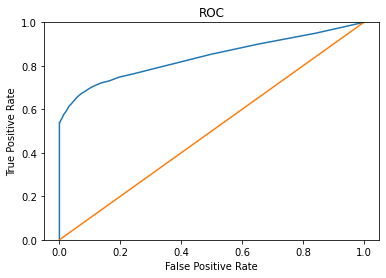

In [22]:
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1])
plt.ylim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.show()

In [29]:
# use the approach of maximizing true positive rate - false positive rate
error_cutoff = pandas.DataFrame({'cutoff':pandas.Series(thresholds),
                                 'class0_error':pandas.Series(fpr),
                                 'class1_error':1-pandas.Series(tpr)}) 

In [30]:
error_cutoff['optimal_value'] = 1-error_cutoff['class1_error']-error_cutoff['class0_error']
error_cutoff.sort_values('optimal_value', ascending=False).head(1)

,cutoff,class0_error,class1_error,optimal_value
61,0.14,0.07348,0.32593,0.600589


In [27]:
error_cutoff 

,cutoff,class0_error,class1_error,optimal_values,optimal_value
0,2.00,0.000000,0.000000,1.000000,1.000000
1,1.00,0.000000,0.472548,0.527452,0.527452
2,0.99,0.000000,0.507711,0.492289,0.492289
3,0.98,0.000000,0.518404,0.481596,0.481596
4,0.97,0.000000,0.525601,0.474399,0.474399
...,...,...,...,...,...
71,0.04,0.380901,0.811845,-0.192746,-0.192746
72,0.03,0.497485,0.852971,-0.350456,-0.350456
73,0.02,0.653560,0.900062,-0.553622,-0.553622
74,0.01,0.842957,0.950442,-0.793399,-0.793399


creat different experiences based on the model score
create additional verification step for user at risk